# 2023-05-09
# This script paint the regression result which exceed 95 per cent, the index is LSTC and OLR

## import module

In [1]:
from matplotlib import projections
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sys
import matplotlib as mpl


sys.path.append("/home/sun/mycode/module/")
from module_sun import *

sys.path.append("/home/sun/mycode/paint/")
from paint_lunwen_version3_0_fig2b_2m_tem_wind_20220426 import set_cartopy_tick,save_fig
from paint_lunwen_version3_0_fig2a_tem_gradient_20220426 import add_text

def calculate_threshold_correlation(n=63):
    '''This function calculate the threshold for the given sample number
    list is here: https://wenku.baidu.com/view/fdfece05a6c30c2259019eed.html?_wkts_=1678086714615
    '''
    return 0.20912, 0.24803, 0.32227 # 0.1, 0.05, 0.01

## Read data

In [6]:
# file correlation
corr_file1 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/correlation/correlation_LSTC_OLR_10wind.nc')
corr_file2 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/correlation/correlation_LSTC_OLR_10wind_remove_each_other.nc')

# file regression
f1 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/regression/regression_uv_to_LSTC.nc')
f2 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/regression/regression_uv_to_OLR.nc')
f3 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/regression/regression_msl_to_OLR_remove_LSTC.nc')
f4 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/regression/regression_msl_to_LSTC_remove_OLR.nc')

#print(corr_file1)
print(f3)
#print(np.max(corr_file1['correlation_v_LSTC'].data))

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    rc_msl2    (latitude, longitude) float64 ...
Attributes:
    description:  Create on 17/5/2023. This file include regression from msl ...


## Some functions

In [3]:
def add_vector_legend(ax,q,location=(0.825, 0),length=0.175,wide=0.2,fc='white',ec='k',lw=0.5,order=1,quiver_x=0.915,quiver_y=0.125,speed=10,fontsize=18):
    '''
    句柄 矢量 位置 图例框长宽 表面颜色 边框颜色  参考箭头的位置 参考箭头大小 参考label字体大小
    '''
    rect = mpl.patches.Rectangle((location[0], location[1]), length, wide, transform=ax.transAxes,    # 这个能辟出来一块区域，第一个参数是最左下角点的坐标，后面是矩形的长和宽
                            fc=fc, ec=ec, lw=lw, zorder=order
                            )
    ax.add_patch(rect)

    ax.quiverkey(q, X=quiver_x, Y=quiver_y, U=speed,
                    label=f'{speed} m/s', labelpos='S', labelsep=0.1,fontproperties={'size':fontsize})

def save_fig(path_out,file_out,dpi=450):
    plv3_1.check_path(path_out)
    plt.savefig(path_out+file_out,dpi=450)

def set_cartopy_tick(ax, extent, xticks, yticks, nx=0, ny=0,
    xformatter=None, yformatter=None,labelsize=20):
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    # 本函数设置地图上的刻度 + 地图的范围
    proj = ccrs.PlateCarree()
    ax.set_xticks(xticks, crs=proj)
    ax.set_yticks(yticks, crs=proj)
    # 设置次刻度.
    xlocator = mticker.AutoMinorLocator(nx + 1)
    ylocator = mticker.AutoMinorLocator(ny + 1)
    ax.xaxis.set_minor_locator(xlocator)
    ax.yaxis.set_minor_locator(ylocator)

    # 设置Formatter.
    if xformatter is None:
        xformatter = LongitudeFormatter()
    if yformatter is None:
        yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(xformatter)
    ax.yaxis.set_major_formatter(yformatter)

    # 设置axi label_size，这里默认为两个轴
    ax.tick_params(axis='both',labelsize=labelsize)

    # 在最后调用set_extent,防止刻度拓宽显示范围.
    if extent is None:
        ax.set_global()
    else:
        ax.set_extent(extent, crs=proj)

## Paint picture

In [4]:
def paint_picture(lon, lat, u, v, msl, u_correlation, v_correlation, scale, speed, pic_name, title_name):
    # 绘制图像
    proj    =  ccrs.PlateCarree()
    fig,ax   =  plt.subplots(figsize=(13,10),subplot_kw=dict(projection=ccrs.PlateCarree()))

    # Mask the value
    for i in range(181):
        for j in range(360):
            if np.absolute(u_correlation[i, j]) < 0.25 or np.absolute(v_correlation[i, j]) < 0.25:
                u[i, j] = 0
                v[i, j] = 0

    # 范围设置
    lonmin,lonmax,latmin,latmax  =  45,150,-10,30
    extent     =  [lonmin,lonmax,latmin,latmax]

    # 刻度设置
    set_cartopy_tick(ax=ax,extent=extent,xticks=np.linspace(50,150,6,dtype=int),yticks=np.linspace(-10,30,5,dtype=int),nx=1,ny=1,labelsize=19)

    # 绘制填色图 —— 回归海平面气压场
    im  =  ax.contourf(lon,lat,msl, 21, cmap='coolwarm', alpha=1,extend='both')
    
    # 绘制赤道线
    ax.plot([40,150],[0,0],'--',color='k')

    # 绘制海岸线
    ax.coastlines(resolution='110m',lw=1)

    # 绘制矢量图
    q  =  ax.quiver(lon, lat, u, v, 
                regrid_shape=15, angles='uv',   # regrid_shape这个参数越小，是两门就越稀疏
                scale_units='xy', scale=scale,        # scale是参考矢量，所以取得越大画出来的箭头就越短 LSTC:0.0075
                units='xy', width=0.25,
                transform=proj,
                color='k',linewidth=1.2,headlength = 5, headaxislength = 4, headwidth = 5)
    
    # 加序号
    #plv3_2a.add_text(ax=ax,string="(b)",fontsize=27.5,location=(0.015,0.91))

    # 加矢量图图例
    add_vector_legend(ax=ax,q=q, speed=speed)

    # add title
    ax.set_title(title_name, fontsize=20)

    # 保存图片
    plt.savefig("/home/sun/paint/monthly_variable/regression/"+pic_name)
    plt.show()

TypeError: Length of x (360) must match number of columns in z (1440)

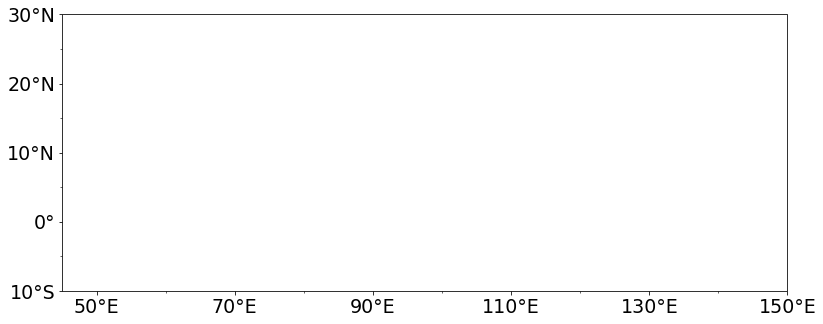

In [7]:
paint_picture(lon=f1.lon,lat=f1.lat,u=f1['rc_u'].data, v=f1['rc_v'].data, msl=f3['rc_msl2'], u_correlation=corr_file1['correlation_u_LSTC'].data, v_correlation=corr_file1['correlation_v_LSTC'].data, scale=0.0075, speed=0.02, pic_name="925_UV_regression_LSTC.pdf", title_name="925 wind regression to LSTC")




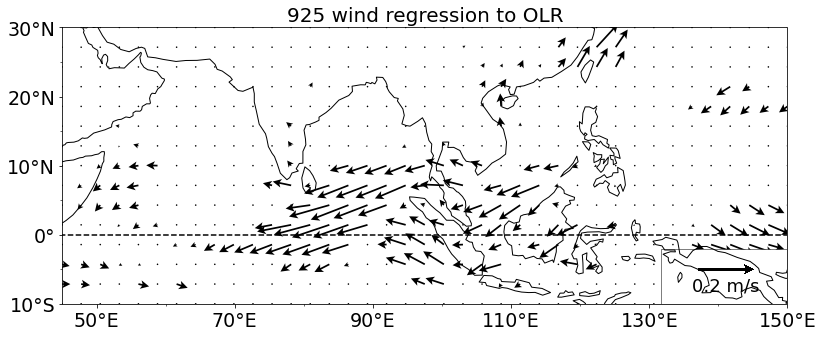

In [6]:
paint_picture(lon=f1.lon,lat=f1.lat,u=f2['rc_u'].data, v=f2['rc_v'].data, u_correlation=corr_file1['correlation_u_OLR'].data, v_correlation=corr_file1['correlation_v_OLR'].data, scale=0.025, speed=0.2, pic_name="925_UV_regression_OLR.pdf", title_name="925 wind regression to OLR")

In [7]:
f3 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/regression/regression_uv_to_LSTC_remove_OLR.nc')
f4 = xr.open_dataset('/home/sun/data/ERA5_data_monsoon_onset/regression/regression_uv_to_OLR_remove_LSTC.nc')

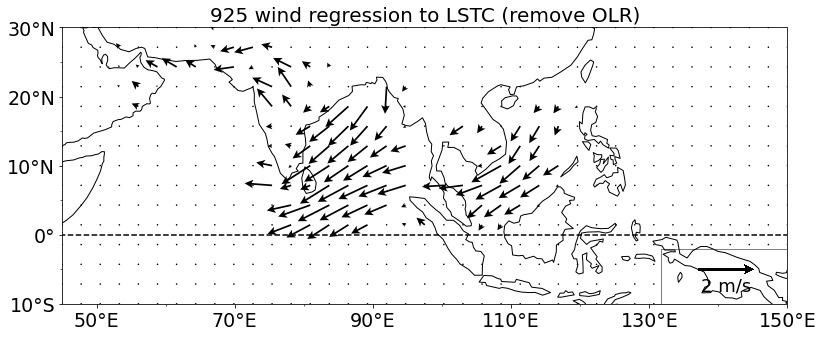

In [8]:
paint_picture(lon=f1.lon,lat=f1.lat,u=f3['rc_u'].data, v=f3['rc_v'].data, u_correlation=corr_file2['correlation_u_LSTC'].data, v_correlation=corr_file2['correlation_v_LSTC'].data, scale=0.25, speed=2, pic_name="925_UV_regression_LSTC_remove_OLR.pdf", title_name="925 wind regression to LSTC (remove OLR)")

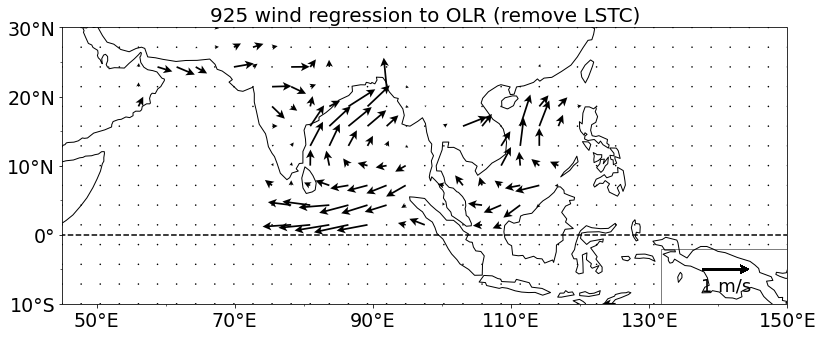

In [9]:
paint_picture(lon=f1.lon,lat=f1.lat,u=f4['rc_u'].data, v=f4['rc_v'].data, u_correlation=corr_file2['correlation_u_LSTC'].data, v_correlation=corr_file2['correlation_v_LSTC'].data, scale=0.15, speed=1, pic_name="925_UV_regression_OLR_remove_LSTC.pdf", title_name="925 wind regression to OLR (remove LSTC)")